In [104]:
import pandas as pd, numpy as np, seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from scipy import stats
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline


# Business Understanding- How are Winning DFS Rosters Constructed 

1.) What player stacking construction is most optimal?

2.) Are QBs in higher total games over owned?

3.) Should we roster lower owned QBs

4.) How contrarian do lineup ownership percentages need to be to finish in the top .25%?

5.) What position should I play in my flex?

# Data exploration

In [105]:
'''
Load Data and check for null values
'''

df=pd.read_csv('flea_flicker_contest_history.csv',delimiter=None)
df.count()/df.shape[0]

lineup_id                       1.0
flex_pos                        1.0
team_players                    1.0
lineup_fp                       1.0
lineup_salary                   1.0
lineup_avg_ownership            1.0
top_3_salary                    1.0
lineup_home_away                1.0
qb_salary                       1.0
qb_team_total                   1.0
qb_spread                       1.0
qb_ownership                    1.0
defense_salary                  1.0
total_wr_salary                 1.0
total_te_salary                 1.0
total_rb_salary                 1.0
defense_spread                  1.0
qb_stack                        1.0
opp_stack                       1.0
stack_game_total                1.0
rb_same                         1.0
wr_same                         1.0
te_same                         1.0
rb_opp                          1.0
wr_opp                          1.0
te_opp                          1.0
rb_defense_stack                1.0
total_games_lineup          

In [106]:
'''
Determining what percentage of our lineups are top place
'''

df.groupby('top_place')['lineup_id'].count()/df.shape[0]

top_place
0    0.99905
1    0.00095
Name: lineup_id, dtype: float64

In [107]:
''' 
Recalibrating top place to represent the top .25% of contest entries rather than the top 20 places as each tournament
has a varying number of entries

This stackoverflow post was used for the methodology: 
http://jonathansoma.com/lede/foundations/classes/pandas%20columns%20and%20functions/apply-a-function-to-every-row-in-a-pandas-dataframe/
'''

top_place_df=df.groupby(['week'])['lineup_id'].count()*.0025

def det_top_place(row, df=top_place_df):
    '''Input: 
    row- row of the dataframe
    top_place_df- df grouped by week and shows what place is .25%
    
    Output:
    determine if the place of the entry is in the top .25%
    '''
    
    threshold=df.loc[row['week']]
    if row['place']<= threshold:
        return 1
    else:
        return 0
    
df['top_place']=df.apply(det_top_place, axis=1)

## What game stacking strategies appear most in winning lineups?

In [108]:
'''
Creating a new attribute, stack_type, as a 6 character string to view how a lineup stacked players with their QB.
character 1- How many RBs from the same team as the QB
character 2 - Howe many Wrs from the same team as the QB
character 3- How many TEs from the same team as the QB
character 4- How many RBs from the opp team of the QB
character 5 - How many WRs from the opp team of the QB
character 6- How many TEs from the opp team of the QB
'''

df['stack_type']= df['rb_same'].astype(str) + df['wr_same'].astype(str)+ df['te_same'].astype(str) \
+df['rb_opp'].astype(str) + df['wr_opp'].astype(str)+ df['te_opp'].astype(str)

df.drop(['rb_same', 'wr_same', 'te_same', 'rb_opp', 'wr_opp', 'te_opp', 'qb_stack', 'opp_stack'], axis=1, inplace=True)

[Text(0, 0.5, 'Percent'), Text(0.5, 0, 'Stack Type')]

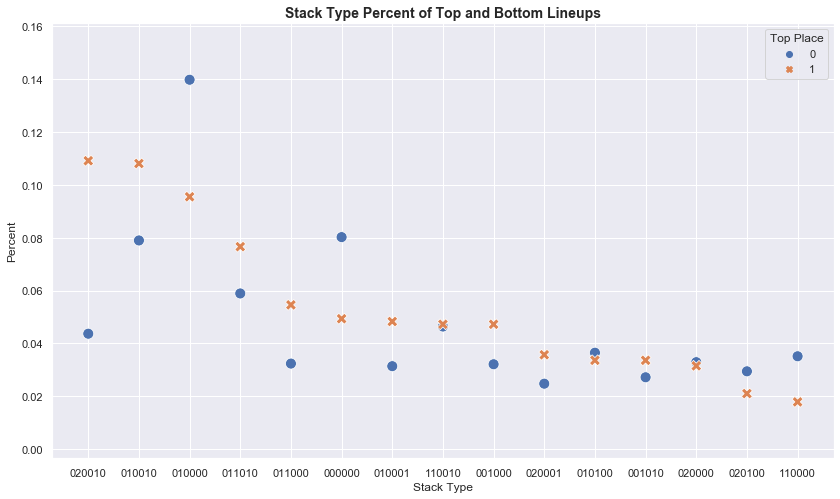

In [109]:
'''
Plotting the the percent a stack type made up of top percent lineups vs the percent it made up of 
non-top percent lineups.  X's above the circle means a lineup stack is outperforming
'''

sns.set(rc={'figure.figsize':(14,8)})
stack_type_chart=sns.scatterplot(data=pd.crosstab(df['stack_type'], df['top_place'], normalize='columns')\
.sort_values(by=1, ascending=False).head(15),  s=120)

stack_type_chart.legend(title='Top Place')
stack_type_chart.set_title('Stack Type Percent of Top and Bottom Lineups', weight='bold', fontsize='14')
stack_type_chart.set(xlabel='Stack Type', ylabel='Percent')

## Are QBs of high total games over owned?

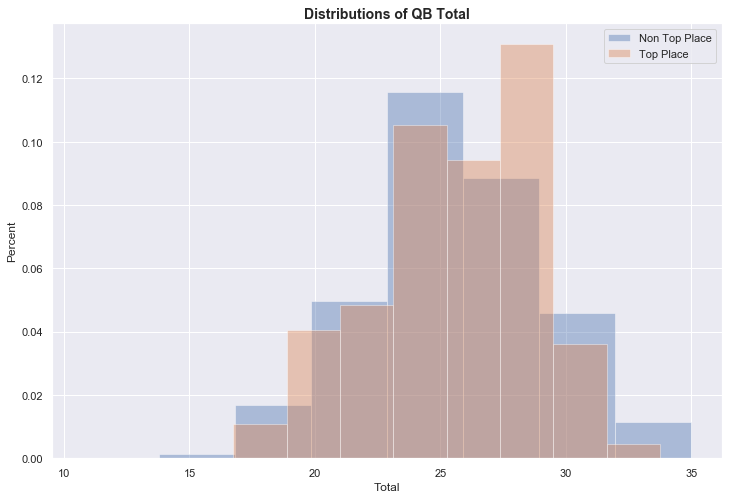

In [110]:
'''
We are ploting the distributions of QB team totals of lineups which finished in in the top percent vs 
non top place
'''

sns.set(rc={'figure.figsize':(12,8)})
non_top_total=sns.distplot(df[(df['top_place']==0)]['qb_team_total'], label='Non Top Place', bins=8, kde=False, norm_hist=True)
top_place_total=sns.distplot(df[(df['top_place']==1)]['qb_team_total'], label='Top Place', bins=8, kde=False, norm_hist=True)

non_top_total.set_title('Distributions of QB Total', weight='bold', fontsize='14')
non_top_total.set(xlabel='Total', ylabel='Percent')
plt.legend()

## Is there value in rostering lower owned QBs

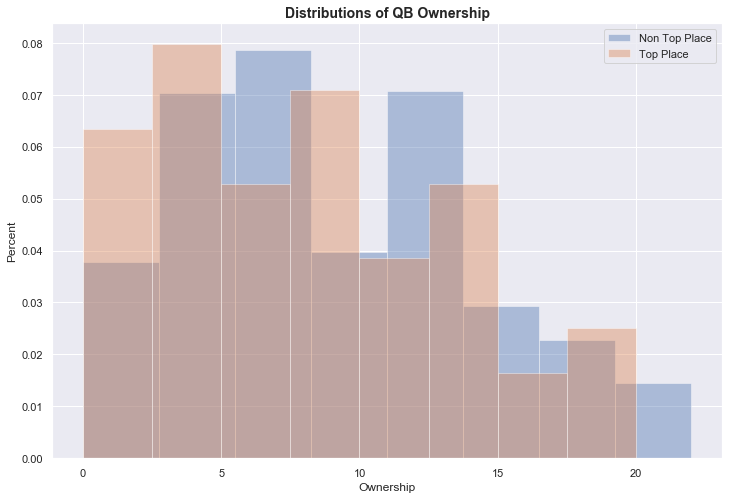

In [111]:
'''
We are ploting the distributions of QB team Ownership of lineups which finished in in the top percent vs 
non top place
'''

sns.set(rc={'figure.figsize':(12,8)})
non_top_own=sns.distplot(df[(df['top_place']==0)]['qb_ownership'], label='Non Top Place', bins=8, kde=False, norm_hist=True)
top_place_own=sns.distplot(df[(df['top_place']==1)]['qb_ownership'], label='Top Place', bins=8, kde=False, norm_hist=True)

non_top_own.set_title('Distributions of QB Ownership', weight='bold', fontsize='14')
non_top_own.set(xlabel='Ownership', ylabel='Percent')
plt.legend()

## How contrarian do lineups need to be to finish in the top .25%

Text(0.5, 1.0, 'Distributions of Avg Lineup Ownership')

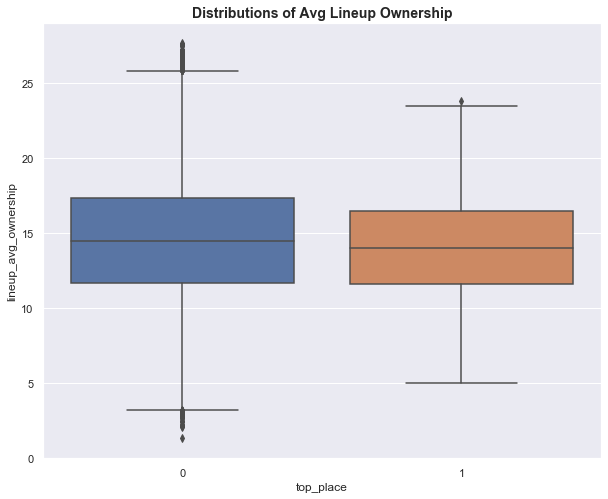

In [112]:
'''
Comparing the distribution of lineup ownership in top place and non top place lineups
'''

sns.set(rc={'figure.figsize':(10,8)})
avg_ownership=sns.boxplot(y=df['lineup_avg_ownership'], x=df['top_place'])
avg_ownership.set_title('Distributions of Avg Lineup Ownership', weight='bold', fontsize='14')

## What type of roster position should be played in our flex

[Text(0, 0.5, 'Percent'), Text(0.5, 0, 'Flex Position')]

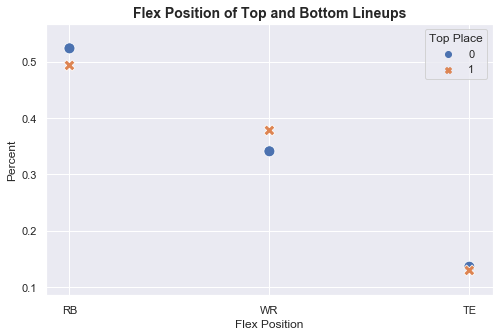

In [113]:
'''
Comparing the flex position in top place and non top place lineups
'''

sns.set(rc={'figure.figsize':(8,5)})
flex_chart=sns.scatterplot(data=pd.crosstab(df['flex_pos'], df['top_place'], normalize='columns')\
.sort_values(by=1, ascending=False).head(15),  s=120)

flex_chart.legend(title='Top Place')
flex_chart.set_title('Flex Position of Top and Bottom Lineups', weight='bold', fontsize='14')
flex_chart.set(xlabel='Flex Position', ylabel='Percent')

# Data Preparation

In [114]:
'''
We are removing columns that are not needed for prediction as well as narrowing the the non-top place lineups
so we don't receive a out of memory.  Randomly sampling the non_top place entries also helps to balance out the classes
a bit more.
'''

weeks=df['week'].unique()
total_majority_samples=75000
total_week_samples=int(total_majority_samples/len(weeks))
df_lists=[]

df_lists.append(df[(df['top_place']==1)])
for week in weeks:
    df_lists.append(df[(df['top_place']==0)& (df['week']==week)].sample(total_week_samples, random_state=2))

final_df=pd.concat(df_lists)
final_df.drop(['place', 'week', 'lineup_id', 'lineup_fp', 'team_players'], axis=1, inplace=True)
final_df=pd.get_dummies(final_df)

In [115]:
'''
Breaking the final dataframe up into training and testing sets
'''
y=final_df['top_place']
x=final_df.drop('top_place', axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

# Modeling

In [116]:
def numerical_cat_variables(df):
    '''
    Input: DataFrame
    Outputs: A list of category columns vs list of numerical columns
    
    '''
    numerical=[]
    cat=[]
    for column, data_type in zip(df.columns, df.dtypes):
        if data_type=='object' or data_type=='uint8':
            cat.append(column)
        else:
            numerical.append(column)
    return(cat, numerical)

In [117]:
'''
We created a column transformer used to scale numerical columns in our pipeline.  Used below site for reference:
https://machinelearningmastery.com/columntransformer-for-numerical-and-categorical-data/
'''

cat_variables, num_variables=numerical_cat_variables(x)
t = [('num', StandardScaler(), num_variables)]
col_transform = ColumnTransformer(transformers=t, remainder='passthrough')

In [118]:
'''
Used below site for help creating function:
https://www.dezyre.com/recipes/plot-roc-curve-in-python

'''

def plot_roc_curve(pipeline, y_test, x_test, model):
    '''
    Input: 
    pipeline- A fitted pipeline
    y_test- y test variables
    x_test- x test variables
    model- string of model name
    
    Outputs: A ROC curve
    
    '''
    y_prob = pipeline.predict_proba(x_test)[:,1]
    false_positive_rate, true_positive_rate, threshold = metrics.roc_curve(y_test, y_prob)
    plt.subplots(1, figsize=(10,10))
    plt.title('Receiver Operating Characteristic'+'-'+model, weight='bold', fontsize='14')
    plt.plot(false_positive_rate, true_positive_rate)
    plt.plot([0, 1], ls="--")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## Finding the best type of model

Gradient_Boosting ROC AUC Score 0.8735414598581603


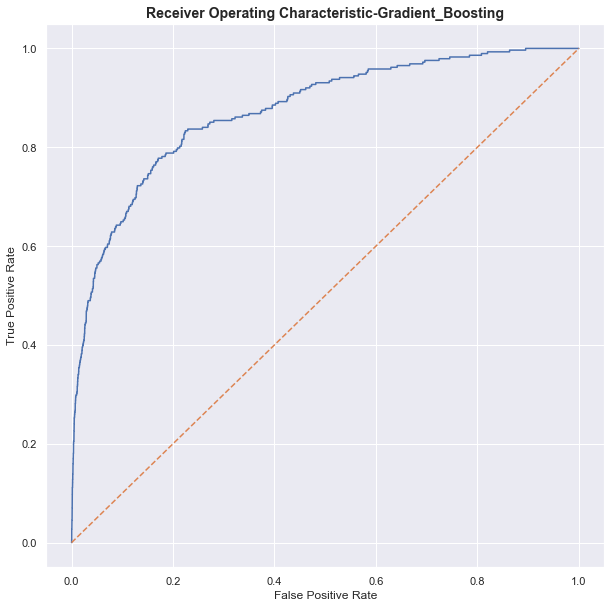

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     22498
           1       0.38      0.05      0.08       288

    accuracy                           0.99     22786
   macro avg       0.69      0.52      0.54     22786
weighted avg       0.98      0.99      0.98     22786



c:\users\travi\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random_Forrest ROC AUC Score 0.7367791488873084


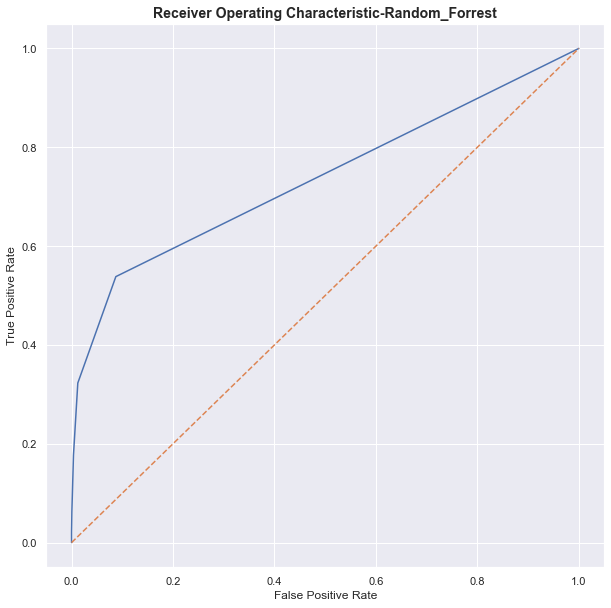

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     22498
           1       0.69      0.03      0.06       288

    accuracy                           0.99     22786
   macro avg       0.84      0.52      0.53     22786
weighted avg       0.98      0.99      0.98     22786



c:\users\travi\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic_Regression ROC AUC Score 0.6716502886676345


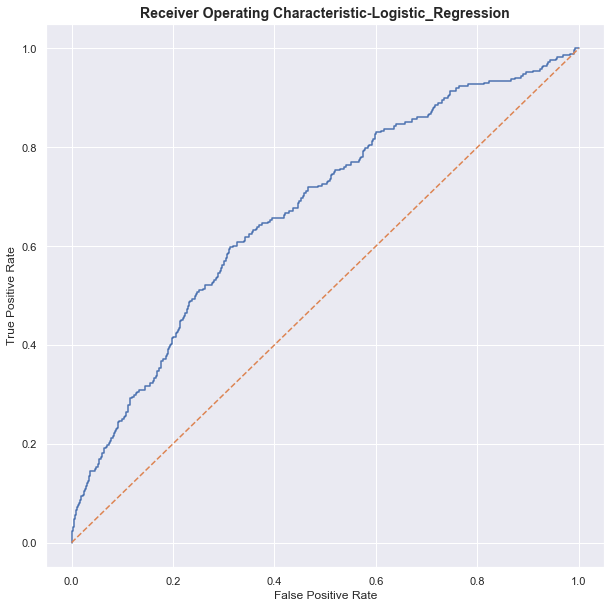

              precision    recall  f1-score   support

           0       0.99      0.63      0.77     22498
           1       0.02      0.64      0.04       288

    accuracy                           0.63     22786
   macro avg       0.51      0.64      0.41     22786
weighted avg       0.98      0.63      0.76     22786



In [126]:
'''
We are looping through different models to try to determine which models perform the best.  Roc_AUC_Score was 
chosen to compare models as the classes are extremely inbalanced.  In order to try and combat the inbalance 
both the RandomForrest and Logistic regression classifiers used a class_wight of balanced to help improve the
recall of the minority class
'''

models={'Gradient_Boosting': GradientBoostingClassifier(), 'Random_Forrest':\
        RandomForestClassifier(class_weight='balanced', n_jobs=-1), 'Logistic_Regression': \
        LogisticRegression(class_weight='balanced')}

for key, model in models.items():
    pipeline=Pipeline([('t', col_transform), ('clf', model)])
    pipeline.fit(x_train, y_train)
    y_pred =pipeline.predict_proba(x_test)[:,1]
    y_pred_class=pipeline.predict(x_test)
    #importances=pipeline[1].feature_importances_
    feature_importance=[]
    print('{} ROC AUC Score {}'.format(key,metrics.roc_auc_score(y_test, y_pred)))
    plot_roc_curve(pipeline, y_test, x_test, key)
    
    print(metrics.classification_report(y_test, y_pred_class))

## Grid searching our best model

In [120]:
'''
Preparing a gridsearch parameters to optimize best model
'''

pipeline=Pipeline([('t', col_transform), ('clf', GradientBoostingClassifier())])
dec_param_grid = { "clf__max_depth": [2,3,4],  "clf__n_estimators": [10, 50, 100],
                 "clf__max_features": ['auto','log2']}
clf_grid=GridSearchCV(pipeline, param_grid=dec_param_grid, scoring='roc_auc', n_jobs=-1, cv=3)

In [121]:
'''
Fitting the gridsearch model and finding the best estimator
'''

clf_grid.fit(x_train,y_train)
clf=clf_grid.best_estimator_


Gradient Boosting ROC AUC Score 0.8952672336306438


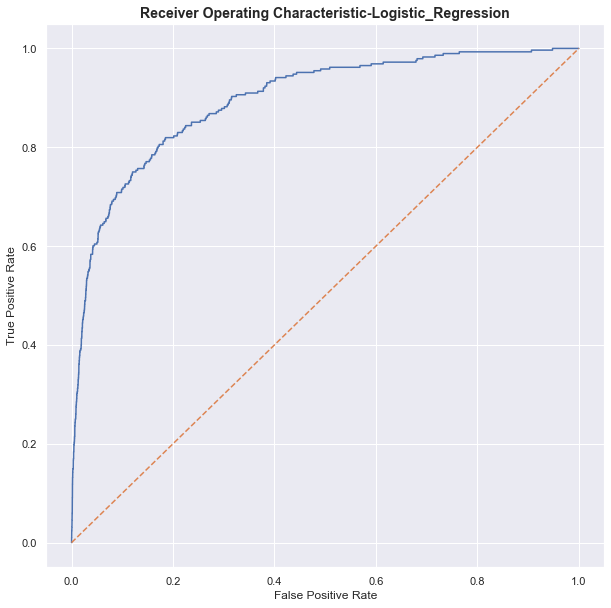

In [122]:
'''
Looking at our ROC Curve and ROC score
'''
y_pred =clf.predict_proba(x_test)[:,1]
print('{} ROC AUC Score {}'.format('Gradient Boosting',metrics.roc_auc_score(y_test, y_pred)))
plot_roc_curve(clf, y_test, x_test, key)

In [123]:
'''
Viewing the classification Report and the Confusion matrix so we have a better idea of the performance of the model
'''

y_pred_class=clf.predict(x_test)
matrix = metrics.confusion_matrix(y_test, y_pred_class)
print(metrics.classification_report(y_test, y_pred_class))
print(matrix)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     22498
           1       0.36      0.06      0.10       288

    accuracy                           0.99     22786
   macro avg       0.67      0.53      0.55     22786
weighted avg       0.98      0.99      0.98     22786

[[22468    30]
 [  271    17]]


In [124]:
'''
The top 20 most important features
'''

importances=clf[1].feature_importances_
feature_importances=[]
for column, feature in zip(x_train.columns, importances):
    feature_importances.append([column, feature])
    
pd.DataFrame(feature_importances, columns=['feature', 'importance']).sort_values(by='importance', ascending=False).head(20)

,feature,importance
13,stack_game_total,0.096314
12,defense_spread,0.084894
10,total_te_salary,0.076923
2,top_3_salary,0.076831
4,qb_salary,0.076270
5,qb_team_total,0.075211
1,lineup_avg_ownership,0.071219
6,qb_spread,0.070487
7,qb_ownership,0.056110
9,total_wr_salary,0.046919


In [125]:
'''
Features of our optimized model
'''

clf[1]

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=4,
                           max_features='auto', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)